In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn, optim
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.distributions import Categorical, Normal, Multinomial, Binomial, MultivariateNormal, Beta, constraints
from pyro.distributions.torch import Bernoulli
import pyro.infer as infer
from pyro.infer import TraceEnum_ELBO, Trace_ELBO, config_enumerate, SVI
from pyro import poutine

plt.style.use('seaborn-v0_8')

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pyro.set_rng_seed(1000)
torch.manual_seed(555450)
k = 3
d = 2
locs = torch.tensor([(1, 12), (-15, -10),  (32.5, 27.8)]).type(torch.FloatTensor)
scales = [torch.block_diag(torch.tensor([5]), torch.tensor([3.25])),
          torch.block_diag(torch.tensor([1.75]), torch.tensor([4.75])),
          torch.block_diag(torch.tensor([1]), torch.tensor([0.5])),
          
          ]

weights = torch.tensor([0.38, 0.12, 0.5])
gauss_dists = [dist.MultivariateNormal(loc, scales[i]) for i, loc in enumerate(locs.unbind())]
indices = [d for d in torch.multinomial(weights, 10000, replacement=True)]
data = [ gauss_dists[d].sample() for d in indices]

In [3]:
X, Y = torch.meshgrid(torch.arange(-20, 40, 0.4), 
                      torch.arange(-20, 40, 0.4)
                      )
X

/env_nlp/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[-20.0000, -20.0000, -20.0000,  ..., -20.0000, -20.0000, -20.0000],
        [-19.6000, -19.6000, -19.6000,  ..., -19.6000, -19.6000, -19.6000],
        [-19.2000, -19.2000, -19.2000,  ..., -19.2000, -19.2000, -19.2000],
        ...,
        [ 38.8000,  38.8000,  38.8000,  ...,  38.8000,  38.8000,  38.8000],
        [ 39.2000,  39.2000,  39.2000,  ...,  39.2000,  39.2000,  39.2000],
        [ 39.6000,  39.6000,  39.6000,  ...,  39.6000,  39.6000,  39.6000]])

In [4]:
Y

tensor([[-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000],
        [-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000],
        [-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000],
        ...,
        [-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000],
        [-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000],
        [-20.0000, -19.6000, -19.2000,  ...,  38.8000,  39.2000,  39.6000]])

In [5]:
probs = gauss_dists[0].log_prob(torch.column_stack((X.flatten(), Y.flatten()))).exp().view(X.size())
probs.size()

torch.Size([150, 150])

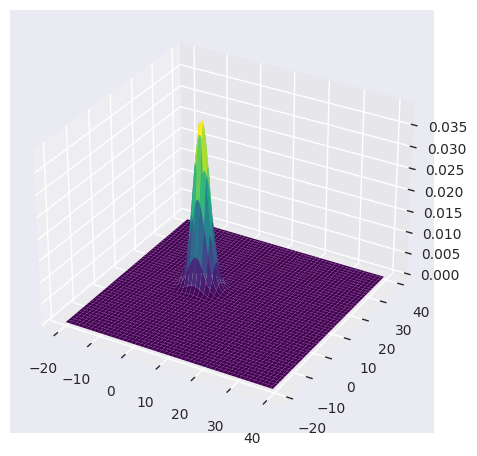

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, probs, cmap=plt.cm.viridis)

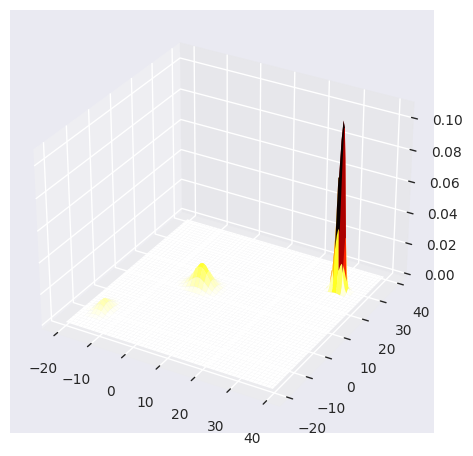

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = torch.meshgrid(torch.arange(-20, 40, 0.4), 
                      torch.arange(-20, 40, 0.4)
                      )
probs = 0.
for i in range(k):
    probs += weights[i] * gauss_dists[i].log_prob(torch.column_stack((X.flatten(), Y.flatten()))).exp().view(X.size())
ax.plot_surface(X, Y, probs, cmap=mpl.cm.hot_r)

In [8]:
test_data = torch.column_stack((X.flatten(), Y.flatten()))
test_data

tensor([[-20.0000, -20.0000],
        [-20.0000, -19.6000],
        [-20.0000, -19.2000],
        ...,
        [ 39.6000,  38.8000],
        [ 39.6000,  39.2000],
        [ 39.6000,  39.6000]])

In [9]:
X

tensor([[-20.0000, -20.0000, -20.0000,  ..., -20.0000, -20.0000, -20.0000],
        [-19.6000, -19.6000, -19.6000,  ..., -19.6000, -19.6000, -19.6000],
        [-19.2000, -19.2000, -19.2000,  ..., -19.2000, -19.2000, -19.2000],
        ...,
        [ 38.8000,  38.8000,  38.8000,  ...,  38.8000,  38.8000,  38.8000],
        [ 39.2000,  39.2000,  39.2000,  ...,  39.2000,  39.2000,  39.2000],
        [ 39.6000,  39.6000,  39.6000,  ...,  39.6000,  39.6000,  39.6000]])

In [10]:
data = torch.stack(data)

In [11]:
def model2(data):
    w = pyro.sample("weights", dist.Dirichlet(torch.ones(k) / k))
    with pyro.plate("mix", k):
        sigma = pyro.sample("sigma", 
                            dist.LogNormal(torch.tensor([1., 1.]), torch.tensor([1, 1])).to_event(1)
                            )
        mean = pyro.sample("mean", dist.Normal(0., torch.tensor([40.]*2)).to_event(1))
    with pyro.plate("data", len(data)):
        z = pyro.sample("z", dist.Categorical(w))
        return pyro.sample("obs", dist.Normal(mean[z], sigma[z]).to_event(1),
                           obs=data)

def guide2(data):
    v1 = pyro.sample("weights", 
                dist.Delta(pyro.param("wloc", lambda: torch.ones(k) / k,  constraint=constraints.simplex)).to_event(1)
            )
    with pyro.plate("mix", k):
        v2 = pyro.sample("mean", 
                dist.Normal(pyro.param("meanloc", lambda: torch.randn(2), ),
                            pyro.param("meansigma", lambda: torch.randn(2).abs(), constraint=constraints.positive)
                            ).to_event(1)
            )
    
        v3 = pyro.sample("sigma", 
                    dist.Delta(pyro.param("sigmaloc", lambda: torch.ones(2), constraint=constraints.positive),
                               ).to_event(1)
                )
        
    with pyro.plate("data", len(data)):
        z_loc = pyro.param("z_loc", lambda: torch.ones(len(data), k) / k,
                           constraint=constraints.simplex)
        z = pyro.sample("z", dist.Categorical(z_loc))

    return {"weights": v1,
            "mean": v2,
            "sigma": v3,
            "z": z,
            }

pyro.clear_param_store()
pyro.set_rng_seed(66666)

optimizer = pyro.optim.Adam({"lr": 3e-4})
svi = SVI(model2, guide2, optimizer, Trace_ELBO())
losses = []

for i in range(6_000):
    losses.append(svi.step(data) / len(data))

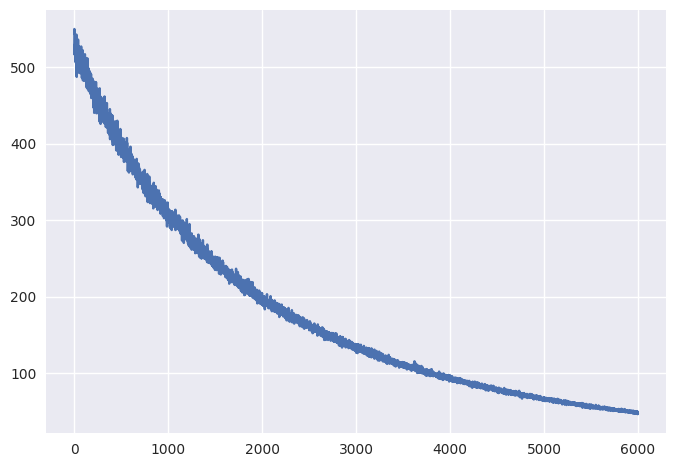

In [12]:
plt.plot(losses)

In [13]:
def get_params(guide):
    with torch.no_grad():
        est = guide(data)
    return est

get_params(svi.guide)

{'weights': tensor([0.3330, 0.3338, 0.3331]),
 'mean': tensor([[ 0.8165, -0.6373],
         [ 0.1968,  0.4008],
         [ 0.4988,  0.6880]]),
 'sigma': tensor([[3.3482, 3.3306],
         [3.3482, 3.3306],
         [3.3482, 3.3306]]),
 'z': tensor([1, 1, 2,  ..., 1, 0, 1])}

In [14]:
(torch.hstack(indices) == get_params(svi.guide)["z"]).sum() / len(data)

tensor(0.3291)

In [15]:
def model3(data):
    w = pyro.sample("weights", dist.Dirichlet(torch.ones(k) / k))
    # w = pyro.sample("weights", dist.Dirichlet(weights))
    with pyro.plate("mix", k):
        sigma = pyro.sample("sigma", 
                            dist.LogNormal(torch.tensor([0., 0.]), torch.tensor([30, 30])).to_event(1)
                            )
        mean = pyro.sample("mean", dist.Normal(0., torch.tensor([40.]*2)).to_event(1))
    with pyro.plate("data", len(data)):
        z = pyro.sample("z", dist.Categorical(w))
        return pyro.sample("obs", dist.Normal(mean[z], sigma[z]).to_event(1),
                           obs=data)

def guide3(data):
    v1 = pyro.sample("weights", 
                dist.Delta(pyro.param("wloc", lambda: torch.ones(k) / k,  constraint=constraints.simplex)).to_event(1)
            )
    with pyro.plate("mix", k):
        v2 = pyro.sample("mean", 
                dist.Normal(pyro.param("meanloc", lambda: torch.randn(2), ),
                            pyro.param("meansigma", lambda: 10 * torch.randn(2).abs(), constraint=constraints.positive)
                            ).to_event(1)
            )
    
        v3 = pyro.sample("sigma", 
                    dist.Delta(pyro.param("sigmaloc", lambda: torch.ones(2), constraint=constraints.positive),
                               ).to_event(1)
                )
        
    with pyro.plate("data", len(data)):
        z_loc = pyro.param("z_loc", lambda: torch.ones(len(data), k) / k,
                           constraint=constraints.simplex)
        z = pyro.sample("z", dist.Categorical(z_loc))

    return {"weights": v1,
            "mean": v2,
            "sigma": v3,
            "z": z,
            }

pyro.clear_param_store()
pyro.set_rng_seed(66666)

optimizer = pyro.optim.Adam({"lr": 3e-2})
svi = SVI(config_enumerate(model3), config_enumerate(guide3), optimizer, TraceEnum_ELBO(max_plate_nesting=2))
losses = []

for i in range(1000):
    losses.append(svi.step(data) / len(data))

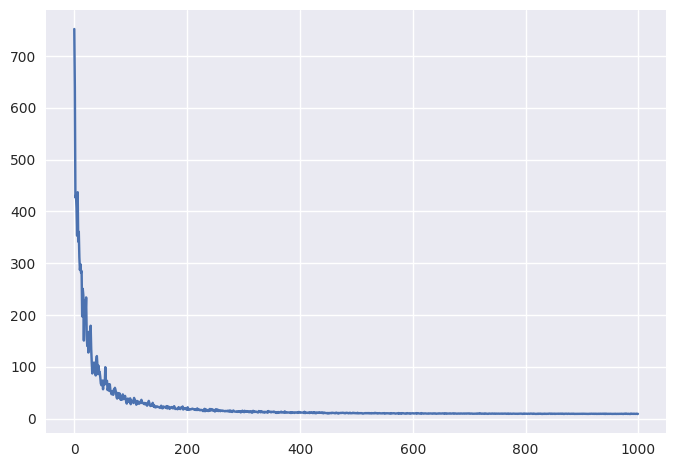

In [16]:
plt.plot(losses)

In [17]:
losses[-10:]

[9.19382890625,
 9.0319640625,
 9.39225859375,
 9.1899140625,
 9.017259375,
 9.08323671875,
 9.019825,
 9.360225,
 8.797771875,
 9.06072734375]

In [18]:
(torch.hstack(indices) == get_params(svi.guide)["z"]).sum() / len(data)

tensor(0.3486)

In [19]:
get_params(svi.guide)

{'weights': tensor([0.4727, 0.2639, 0.2634]),
 'mean': tensor([[1.2954, 0.1599],
         [6.4479, 3.7207],
         [5.6024, 4.4617]]),
 'sigma': tensor([[16.8785, 15.1776],
         [16.8785, 15.1776],
         [16.8785, 15.1776]]),
 'z': tensor([0, 0, 0,  ..., 2, 2, 1])}

In [20]:
weights

tensor([0.3800, 0.1200, 0.5000])